In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import os
import pickle
import random
import sys

import dill
import ivac
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import pyemma
import scipy
import seaborn as sns
from matplotlib import ticker

import extq
import prettypyplot as pplt

In [4]:
from joblib import Memory

In [5]:
! source /project/dinner/scguo/upside2/sourceme.sh

In [6]:
# upside_path = os.environ["UPSIDE_HOME"]
upside_path = "/project/dinner/scguo/upside2/"
upside_utils_dir = os.path.expanduser(upside_path + "/py")
sys.path.insert(0, upside_utils_dir)

In [7]:
plt.style.use("custom")  # custom style sheet
plt.style.use("high-contrast")  # muted color theme from SciencePlots
pplt.load_cmaps()

In [8]:
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath"
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = "cm"

# Load data

In [9]:
def get_traj_ids(base_dir):
    ids = []
    k = 0
    for i in range(1, 12289):
        j = i // 1000
        for iso in ("cis", "trans"):
            head = f"{base_dir}/{j:02}/{i:05}/outputs/{i:05}_{iso}"
            if len(glob.glob(f"{base_dir}/{j:02}/{i:05}/{iso}/*.up")) > 0:
                ids.append(k)
            k += 1
    return np.array(ids)


def get_weights(weights, N, k, ids):
    sampled_w = np.concatenate(weights[:, -N::k])
    # set weight for cis/trans to be the same
    sampled_w = np.repeat(sampled_w, 2)
    return sampled_w[ids]


def load_cv(basename):
    arrays = []
    for file in sorted(glob.glob(f"{basename}_??.npy")):
        arrays.append(np.load(file))
    return np.concatenate(arrays)


def load_all(temp):
    base_dir = f"{home_dir}/dga/new_{temp}"
    data_dir = f"{base_dir}/data"
    weights = np.load(f"{data_dir}/mbar_weights.npy")
    ids = get_traj_ids(base_dir)
    N = 32000
    k = 1000
    sample_w = get_weights(weights, N, k, ids)

    fs_qtots = load_cv(f"{data_dir}/fs_qtots")
    q_gs_all = load_cv(f"{data_dir}/q_gs_all")
    q_gs = load_cv(f"{data_dir}/q_gs")
    q_fs_all = load_cv(f"{data_dir}/q_fs_all")
    q_fs = load_cv(f"{data_dir}/q_fs")
    q_core = load_cv(f"{data_dir}/q_core")
    omegas = load_cv(f"{data_dir}/omegas")
    pots = load_cv(f"{data_dir}/pots")
    f_rmsds = load_cv(f"{data_dir}/f_rmsds")
    p_rmsds = load_cv(f"{data_dir}/p_rmsds")

    c_green = fs_qtots[:, 4] - fs_qtots[:, 5]
    c_blue = fs_qtots[:, 6] - fs_qtots[:, 7]
    c_orange = fs_qtots[:, 2] - fs_qtots[:, 3]
    c_0 = fs_qtots[:, 0] - fs_qtots[:, 1]
    n_cis = np.sum((np.abs(omegas[..., 3:]) <= (np.pi / 2.0)).astype(int), axis=-1)
    p63_cis = (np.abs(omegas[..., 3]) <= (np.pi / 2.0)).astype(int)
    p70_cis = (np.abs(omegas[..., 4]) <= (np.pi / 2.0)).astype(int)
    p71_cis = (np.abs(omegas[..., 5]) <= (np.pi / 2.0)).astype(int)
    p72_cis = (np.abs(omegas[..., 6]) <= (np.pi / 2.0)).astype(int)

    cvs = dict(
        blue=c_blue,
        green=c_green,
        orange=c_orange,
        c0=c_0,
        q_gs_all=q_gs_all,
        q_fs_all=q_fs_all,
        q_gs=q_gs,
        q_fs=q_fs,
        q_core=q_core,
        n_cis=n_cis,
        pot=pots,
        f_rmsds=f_rmsds,
        p_rmsds=p_rmsds,
        q_diff=q_fs - q_gs,
        p63=p63_cis,
        p70=p70_cis,
        p71=p71_cis,
        p72=p72_cis,
    )
    return cvs, sample_w

In [10]:
home_dir = "/project/dinner/scguo/kaiB"

In [11]:
cvs_all_ts, weights_all_ts = [], []
qp_all_ts = []
qlag, qmem = 100, 1
for t in [87, 89, 91]:
    cvs, weights = load_all(t)
    cvs_all_ts.append(cvs)
    weights_all_ts.append(weights)
    with open(f"{home_dir}/dga/new_{t}/data/qp_gs2fs.pkl", mode="rb") as f:
        qp_all_ts.append(dill.load(f)[(qlag, qmem)])

In [12]:
labels = dict(
    blue=r"$\beta4_{\mathrm{gs}}\longleftrightarrow\alpha3_{\mathrm{fs}}$",
    green=r"$\alpha3_{\mathrm{gs}}\longleftrightarrow\beta4_{\mathrm{fs}}$",
    orange=r"$\alpha2_{\mathrm{gs}}\longleftrightarrow\beta3_{\mathrm{fs}}$",
    c0=r"$\beta3_{\mathrm{gs}}\longleftrightarrow\alpha2_{\mathrm{fs}}$",
    r_rmsd=r"N-term RMSD (nm)",
    q_gs_all=r"$Q_{\mathrm{gs}}$",
    q_fs_all=r"$Q_{\mathrm{fs}}$",
    q_gs=r"$Q_{\mathrm{gs, C}}$",
    q_fs=r"$Q_{\mathrm{fs, C}}$",
    q_core=r"$Q_{\mathrm{N}}$",
    n_cis=r"$n_{\mathrm{cis}}$",
    q_diff=r"$Q_{\mathrm{fs, C}}-Q_{\mathrm{gs, C}}$",
    qp=r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$",
)
lims = dict(
    blue=(-1.3, 1),
    green=(-1, 1.3),
    orange=(-1, 1.3),
    c0=(-1.3, 1),
    r_rmsd=(0, 1.2),
    q_gs_all=(0, 1),
    q_fs_all=(0, 1),
    q_gs=(0, 1),
    q_fs=(0, 1),
    q_core=(0, 1),
    n_cis=(0, 2),
    q_diff=(-1, 1),
    qp=(0, 1),
)

# some 3d plots

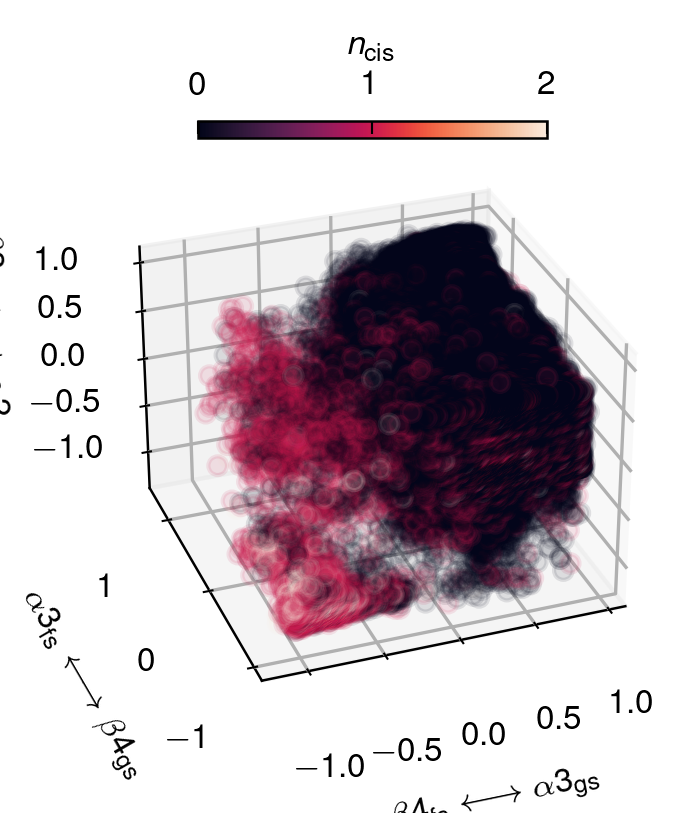

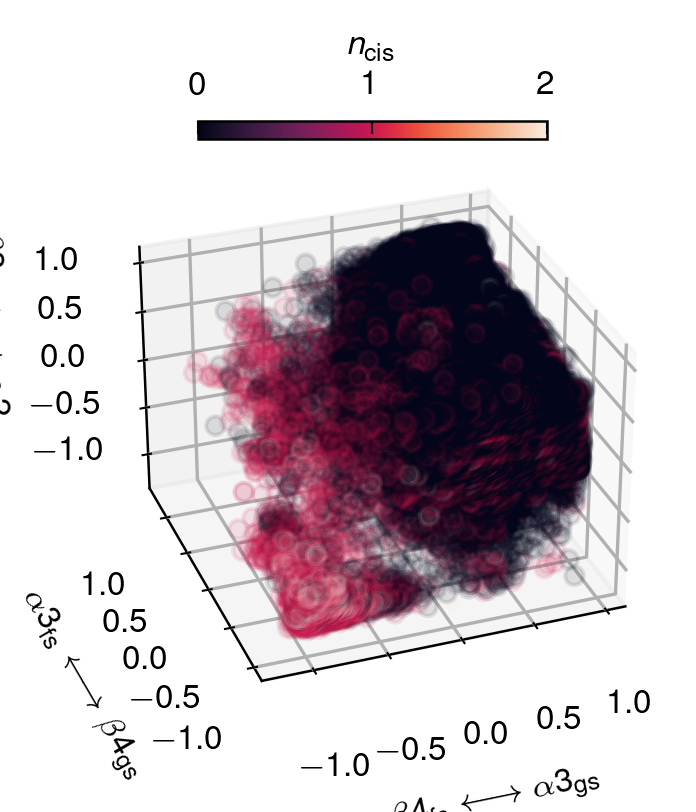

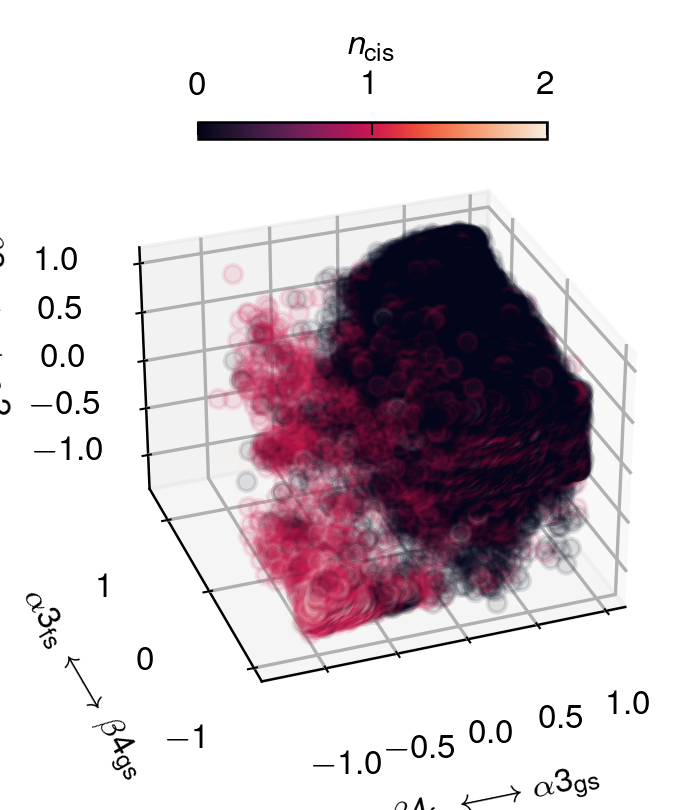

In [12]:
for cvs, qp in zip(cvs_all_ts, qp_all_ts):
    fig = plt.figure(dpi=300)
    q_arr = np.ravel(qp)
    N = len(q_arr)
    skip = 200
    sc_ind = np.random.choice(N, N // skip)
    
    ax = fig.add_subplot(projection="3d")
    sc = ax.scatter(
        cvs['green'].ravel()[sc_ind],
        cvs['blue'].ravel()[sc_ind],
        cvs['orange'].ravel()[sc_ind],
        "o",
        c=cvs['n_cis'].ravel()[sc_ind],
        cmap="rocket",
        alpha=0.1,
        rasterized=True,
        vmin=0,
        vmax=2,
    )
    ax.set_xlabel(labels["green"])
    ax.set_ylabel(labels["blue"])
    ax.set_zlabel(labels["orange"])
    ax.grid(True)
    cb = plt.colorbar(sc, ax=ax, shrink=0.5, location='top', pad=0, label=labels['n_cis'])
    cb.solids.set(alpha=1)
    ax.view_init(elev=30, azim=-110)

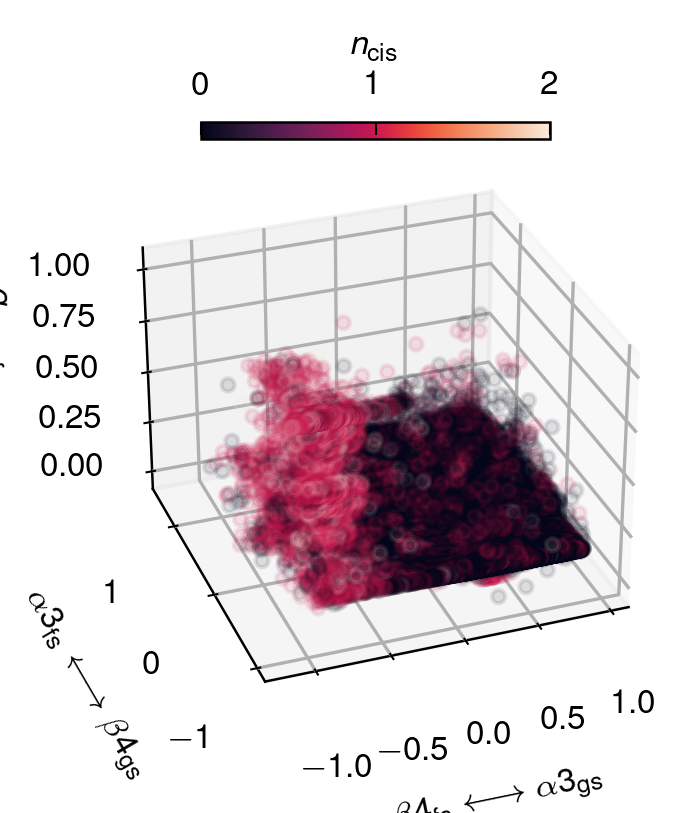

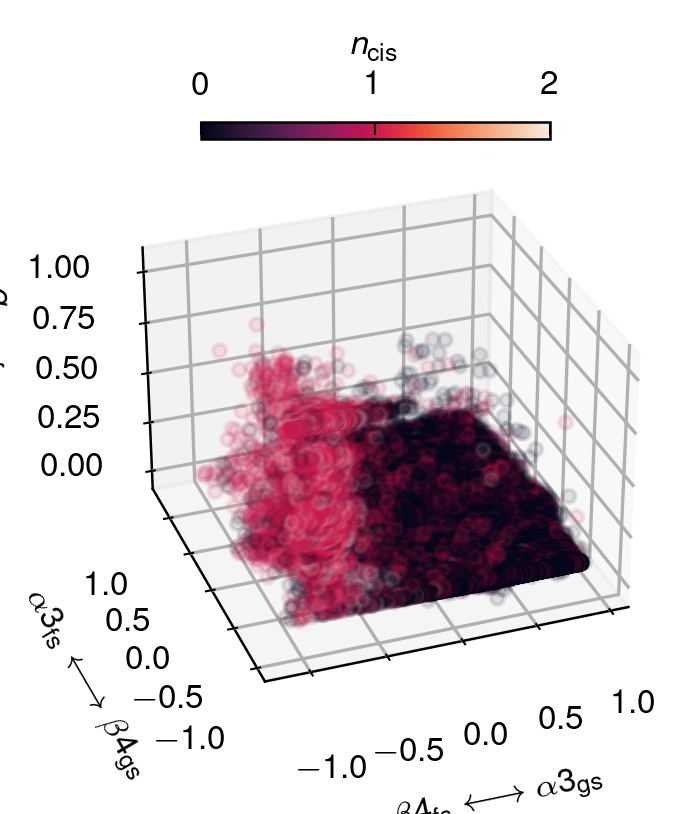

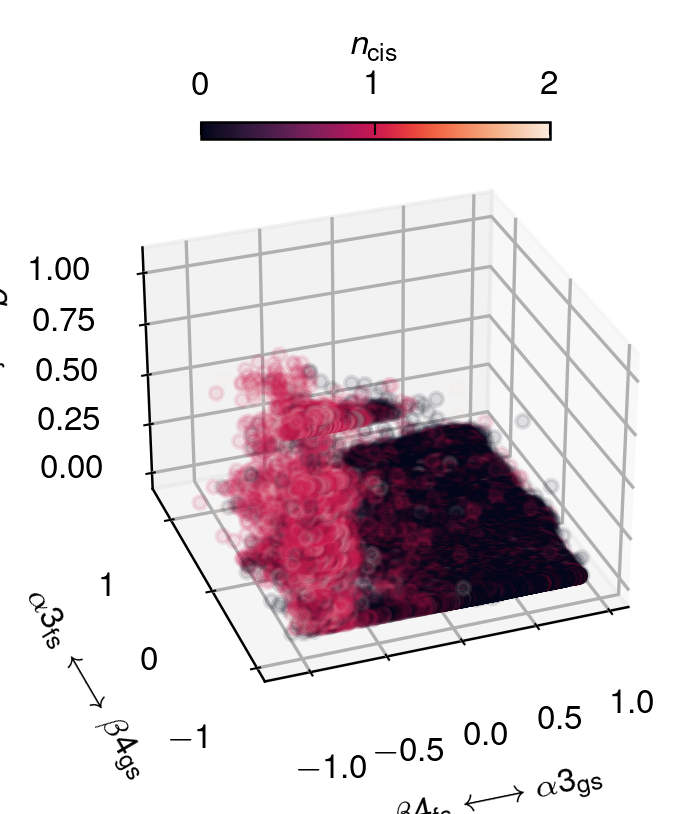

In [13]:
for cvs, qp in zip(cvs_all_ts, qp_all_ts):
    fig = plt.figure(dpi=300)
    q_arr = np.ravel(qp)
    N = len(q_arr)
    skip = 200
    sc_ind = np.random.choice(N, N // skip)
    
    ax = fig.add_subplot(projection="3d")
    sc = ax.scatter(
        cvs['green'].ravel()[sc_ind],
        cvs['blue'].ravel()[sc_ind],
        q_arr[sc_ind],
        "o",
        c=cvs['n_cis'].ravel()[sc_ind],
        cmap="rocket",
        alpha=0.1,
        rasterized=True,
        s=10,
        vmin=0,
        vmax=2,
    )
    ax.set_xlabel(labels["green"])
    ax.set_ylabel(labels["blue"])
    ax.set_zlabel(labels["qp"])
    ax.grid(True)
    cb = plt.colorbar(sc, ax=ax, shrink=0.5, location='top', pad=0, label=labels['n_cis'])
    cb.solids.set(alpha=1)
    ax.view_init(elev=30, azim=-110)

# Plot states/number of cis prolines against committor

In [13]:
def kdesum1d(
    x,
    w,
    *,
    xmin=None,
    xmax=None,
    xstd=None,
    nx=100,
    cut=4.0,
):
    """Compute a 1D kernel density estimate.

    This function histograms the data, then uses a Gaussian filter to
    approximate a kernel density estimate with a Gaussian kernel.

    Parameters
    ----------
    x : ndarray or list/tuple of ndarray
        Coordinates of each frame.
    w : ndarray or list/tuple of ndarray
        Weight or value of each frame. The output is the sum of these
        values in each bin, after smoothing.
    xmin, xmax : float, optional
        Limits of kernel density estimate. If None, takes the min/max
        of the data along the coordinate.
    xstd : float, optional
        Standard deviation of the Gaussian filter. If None, these are
        set to (xmax - xmin) / nx. Increase this to smooth the results more.
    nx : int, optional
        Number of bins in each dimension. This should be set as high as
        reasonable, since xstd takes care of the smoothing.
    cut : float, optional
        Number of standard deviations at which to truncate the Gaussian
        filter. The default, 4, usually doesn't need to be changed.

    Returns
    -------
    kde : (nx,) ndarray
        Kernel density estimate, given as bins.
    xedges : (nx+1,) ndarray
        Bin edges along the x dimension.

    """

    # flatten input to 1D arrays
    x = _flatten(x)
    w = _flatten(w)

    # limits
    _xmin = np.min(x)
    _xmax = np.max(x)
    if xmin is None:
        xmin = _xmin
    if xmax is None:
        xmax = _xmax

    # separation between grid points
    xsep = (xmax - xmin) / nx

    # number of grid points to pad the boundaries,
    # since the Gaussian filter extends beyond the boundaries
    # usually overestimates the padding, but whatever
    ax = max(0, int(np.ceil((xmin - _xmin) / xsep + 1e-6)))
    bx = max(0, int(np.ceil((_xmax - xmax) / xsep + 1e-6)))

    # output bin edges
    xedges = np.linspace(xmin, xmax, nx + 1)

    # bin edges, with the added padding
    xedges_padded = np.concatenate(
        [
            xmin + xsep * np.arange(-ax, 0),
            xedges,
            xmax + xsep * np.arange(1, bx + 1),
        ]
    )
    assert np.allclose(xedges_padded[1:] - xedges_padded[:-1], xsep)
    assert xedges_padded[0] <= _xmin and _xmax <= xedges_padded[-1]

    # construct 2D histogram on padded edges
    hist_padded, _ = np.histogram(x, weights=w, bins=xedges_padded)
    # Gaussian kernel parameters
    if xstd is None:
        xstd = xsep

    # apply Gaussian filter to histogram
    kde_padded = scipy.ndimage.gaussian_filter(
        hist_padded,
        sigma=(xstd / xsep),  # in units of grid points
        mode="constant",
        truncate=cut,
    )

    # remove the padding
    assert ax + nx + bx == kde_padded.shape[0]
    kde = kde_padded[ax : ax + nx]
    return kde, xedges


def _flatten(a):
    if isinstance(a, np.ndarray):
        # avoid creating a new array (and using twice the memory)
        return np.ravel(a)
    else:
        return np.ravel(np.concatenate(a))

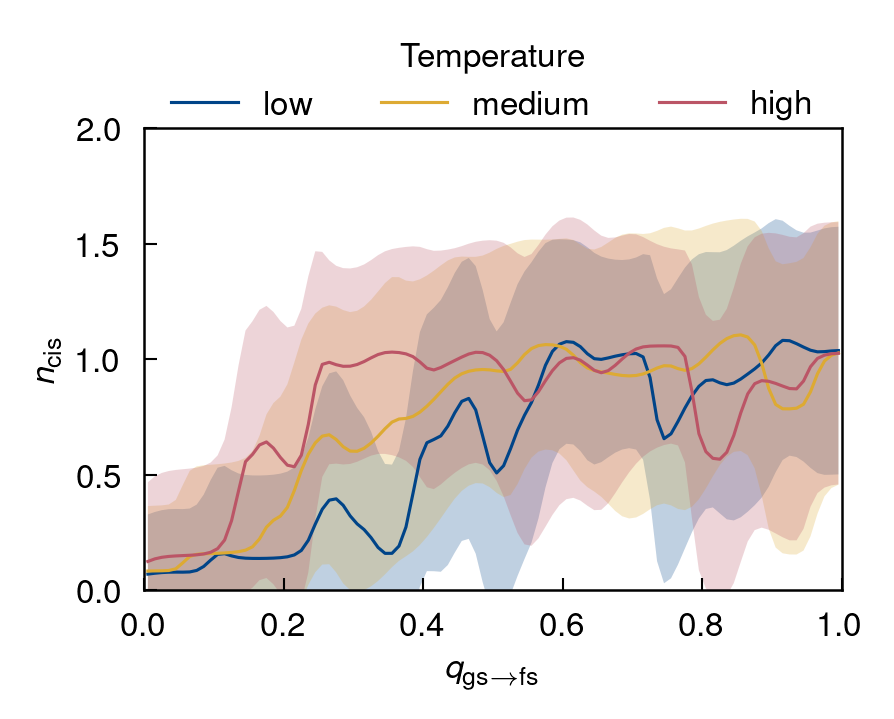

In [14]:
# ncis vs qp
fig = plt.figure(figsize=(3, 2), dpi=300)
cv1 = "n_cis"

lag, mem = 100, 1
xstd = 0.02
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    numer, xe = kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    cvsq, _ = kdesum1d(q, (cvs[cv1][..., :-lag]**2) * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
    mean = numer / denom
    var = (cvsq / denom) - (mean)**2
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
    plt.fill_between(xc, mean - np.sqrt(var), mean + np.sqrt(var), alpha=0.25)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel(labels[cv1])
plt.xlim([0, 1])
plt.ylim(lims[cv1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_qfs_ts.pdf", bbox_inches='tight')
plt.show()

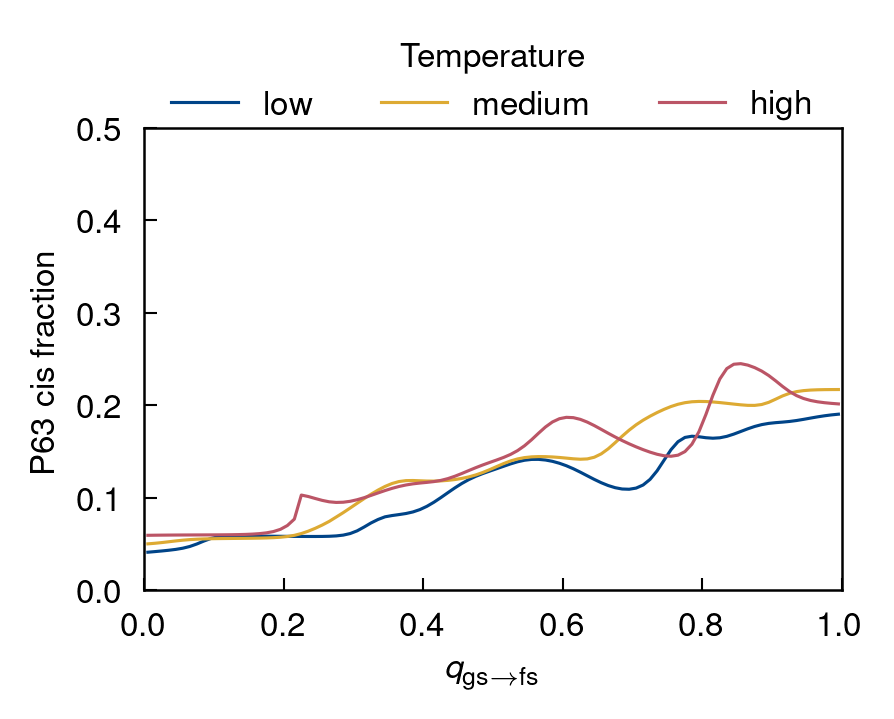

In [15]:
# p63 vs qp
fig = plt.figure(figsize=(3, 2), dpi=300)
cv1 = "p63"

lag, mem = 100, 1
xstd = 0.04
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    numer, xe = kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    # cvsq, _ = kdesum1d(q, (cvs[cv1][..., :-lag]**2) * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
    mean = numer / denom
    # var = (cvsq / denom) - (mean)**2
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
    # plt.fill_between(xc, mean - np.sqrt(var), mean + np.sqrt(var), alpha=0.25)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel("P63 cis fraction")
plt.xlim([0, 1])
plt.ylim([0, 0.5])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
fig.savefig("../../dga/figures/qp_p63_ts.pdf", bbox_inches='tight')
plt.show()

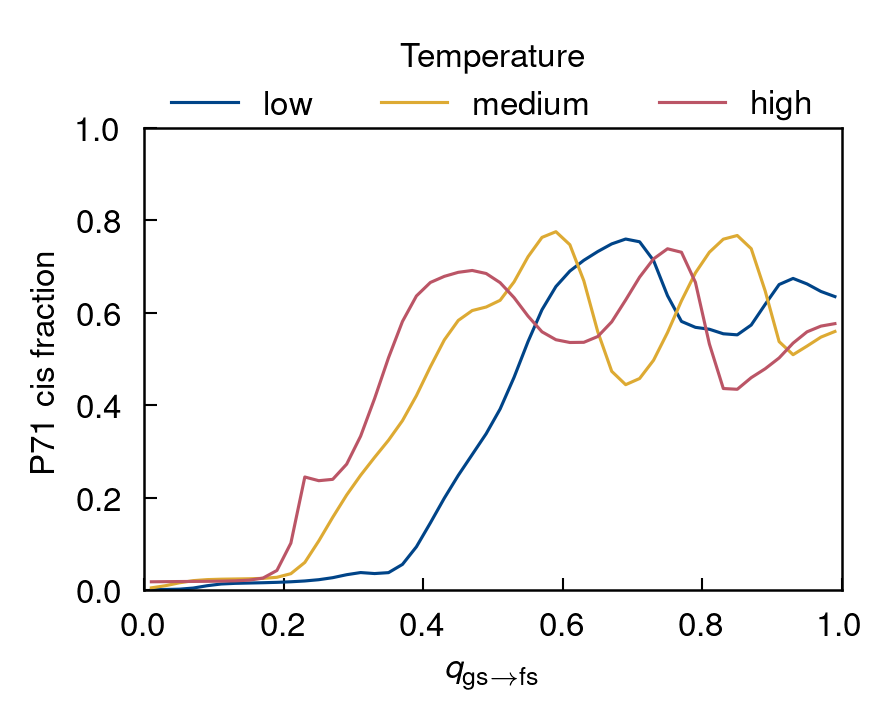

In [16]:
# p71 vs qp
fig = plt.figure(figsize=(3, 2), dpi=300)
cv1 = "p71"

lag, mem = 100, 1
xstd = 0.04
nx = 50
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    numer, xe = kdesum1d(q, cvs[cv1][..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    # cvsq, _ = kdesum1d(q, (cvs[cv1][..., :-lag]**2) * w, xmin=0, xmax=1, xstd=xstd, nx=100)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    # var = (cvsq / denom) - (mean)**2
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
    # plt.fill_between(xc, mean - np.sqrt(var), mean + np.sqrt(var), alpha=0.25)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel("P71 cis fraction")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_qfs_ts.pdf", bbox_inches='tight')
plt.show()

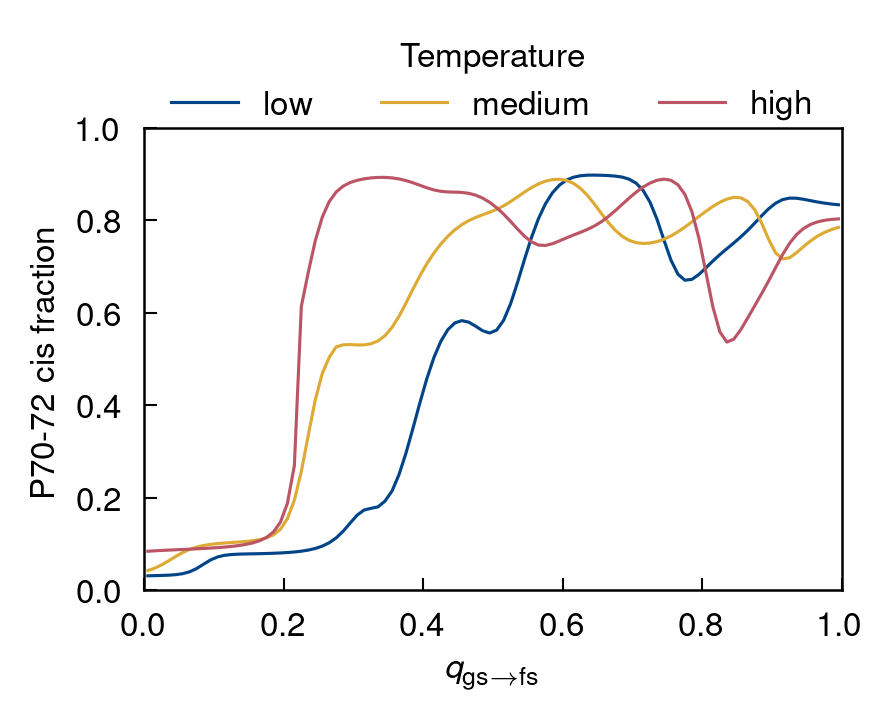

In [17]:
# combine p70-p72
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['p70'] | cvs['p71'] | cvs['p72']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel("P70-72 cis fraction")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

/scratch/local/jobs/18153937/ipykernel_27549/2845125240.py:16: RuntimeWarning: invalid value encountered in divide
  mean = numer / denom


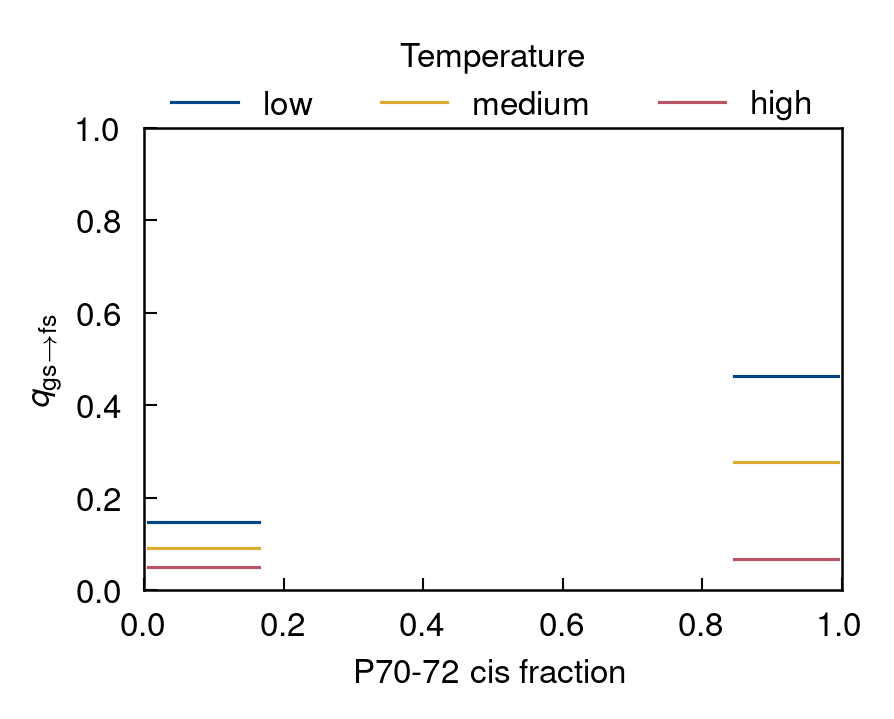

In [18]:
# combine p70-p72
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['p70'] | cvs['p71'] | cvs['p72']
    numer, xe = kdesum1d(cv[..., :-lag], q * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(cv[..., :-lag], w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel("P70-72 cis fraction")
plt.ylabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

/scratch/local/jobs/18029147/ipykernel_1030098/185735953.py:31: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="rocket", vmin=lims[cv3][0], vmax=lims[cv3][1], rasterized=True)


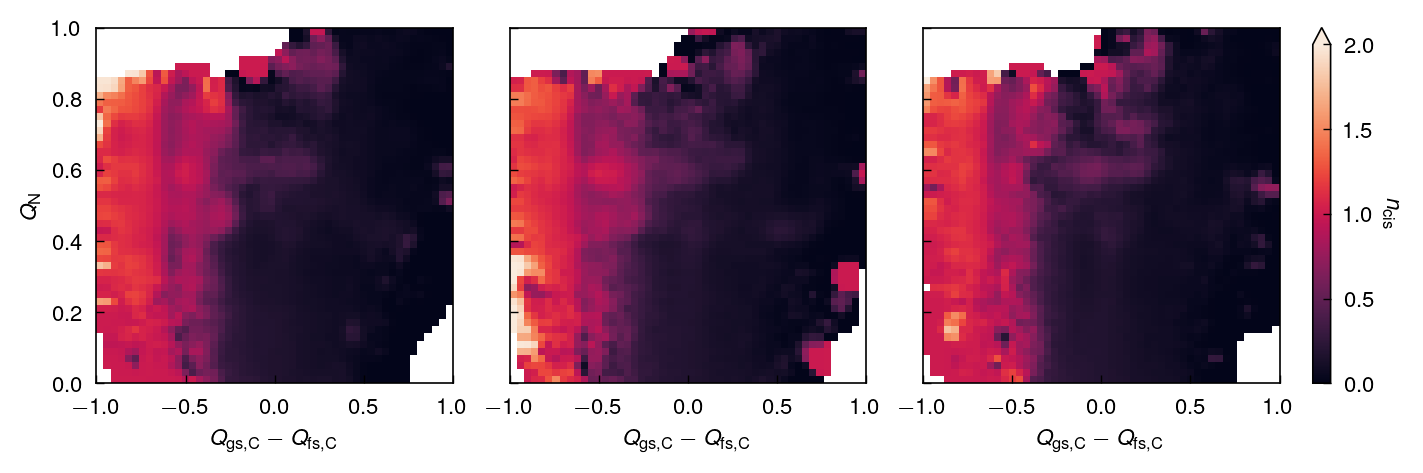

In [21]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
cv3 = "n_cis"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs[cv3]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="rocket", vmin=lims[cv3][0], vmax=lims[cv3][1], rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1], extend='max')
cb.set_label(label=labels[cv3], rotation=-90, labelpad=10)

/scratch/local/jobs/18029147/ipykernel_1030098/1817373499.py:30: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="rocket", vmin=0, vmax=1, rasterized=True)


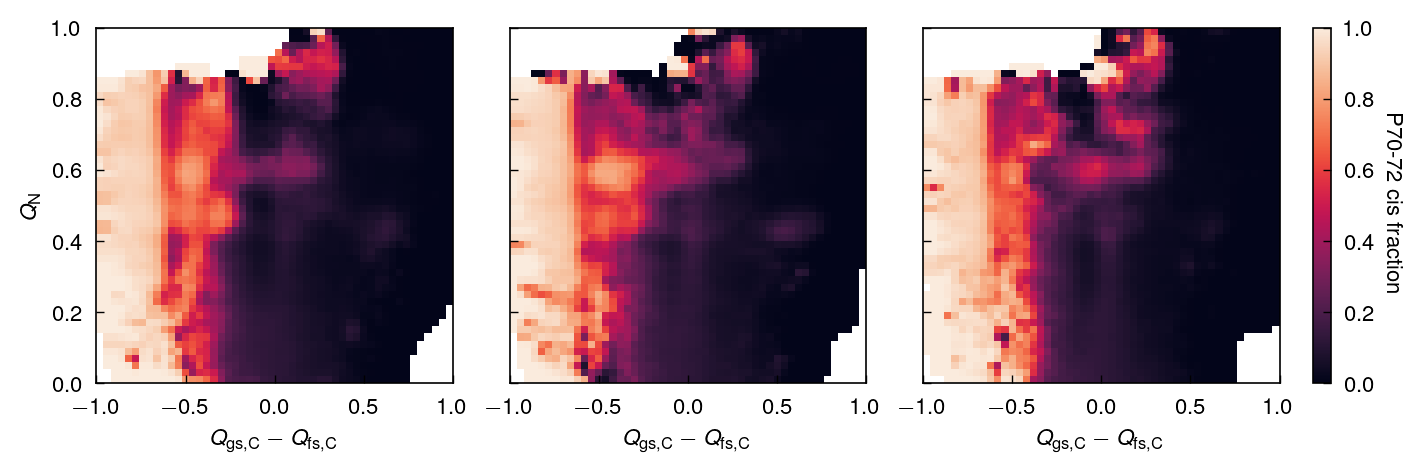

In [22]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 51)
ye = np.linspace(*lims[cv2], 51)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w in zip(axes, cvs_all_ts, weights_all_ts):
    cv1_delay = cvs[cv1]
    cv2_delay = cvs[cv2]
    cv3_delay = cvs['p70'] | cvs['p71'] | cvs['p72']
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    cvw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(cv3_delay) * sample_w[..., None],
        xe,
        ye,
    )
    cvw = scipy.ndimage.gaussian_filter(cvw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (cvw / w).T, cmap="rocket", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label="P70-72 cis fraction", rotation=-90, labelpad=10)

## look at committors for pathway excluding unfolded state

In [23]:
qp_withc_all = []
for t in [87, 89, 91]:
    qp_withc = np.load(f"{home_dir}/dga/new_{t}/data/qp_gs2fs_withc.npy")
    qp_withc_all.append(qp_withc)

/scratch/local/jobs/18029147/ipykernel_1030098/4095826056.py:29: RuntimeWarning: invalid value encountered in divide
  pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)


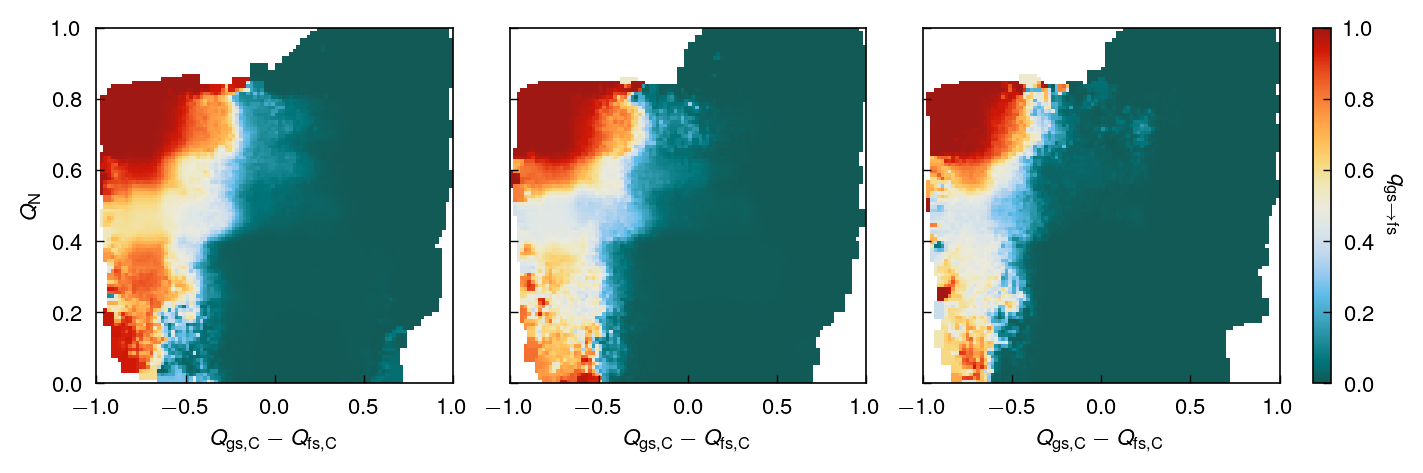

In [24]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(7, 2.25), dpi=200, sharex=True, sharey=True, constrained_layout=True
)
cv1 = "q_diff"
cv2 = "q_core"
xe = np.linspace(*lims[cv1], 101)
ye = np.linspace(*lims[cv2], 101)
xc = (xe[:-1] + xe[1:]) / 2
yc = (ye[:-1] + ye[1:]) / 2
for ax, cvs, sample_w, qp in zip(axes, cvs_all_ts, weights_all_ts, qp_withc_all):
    cv1_delay = cvs[cv1][..., :-qlag]
    cv2_delay = cvs[cv2][..., :-qlag]
    w = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.broadcast_to(sample_w[..., None], cv1_delay.shape),
        xe,
        ye,
    )
    w = scipy.ndimage.gaussian_filter(w, sigma=0.5, mode="constant")
    qw = extq.projection.density2d(
        cv1_delay,
        cv2_delay,
        np.asarray(qp)[..., :-qlag] * sample_w[..., None],
        xe,
        ye,
    )
    qw = scipy.ndimage.gaussian_filter(qw, sigma=0.5, mode="constant")
    pc = ax.pcolormesh(xc, yc, (qw / w).T, cmap="nightfall", vmin=0, vmax=1, rasterized=True)
    ax.set_xlabel(labels[cv1])
    ax.set_ylabel(labels[cv2])
    ax.label_outer()
cb = plt.colorbar(pc, ax=axes[-1])
cb.set_label(label=labels["qp"], rotation=-90, labelpad=10)
plt.show()

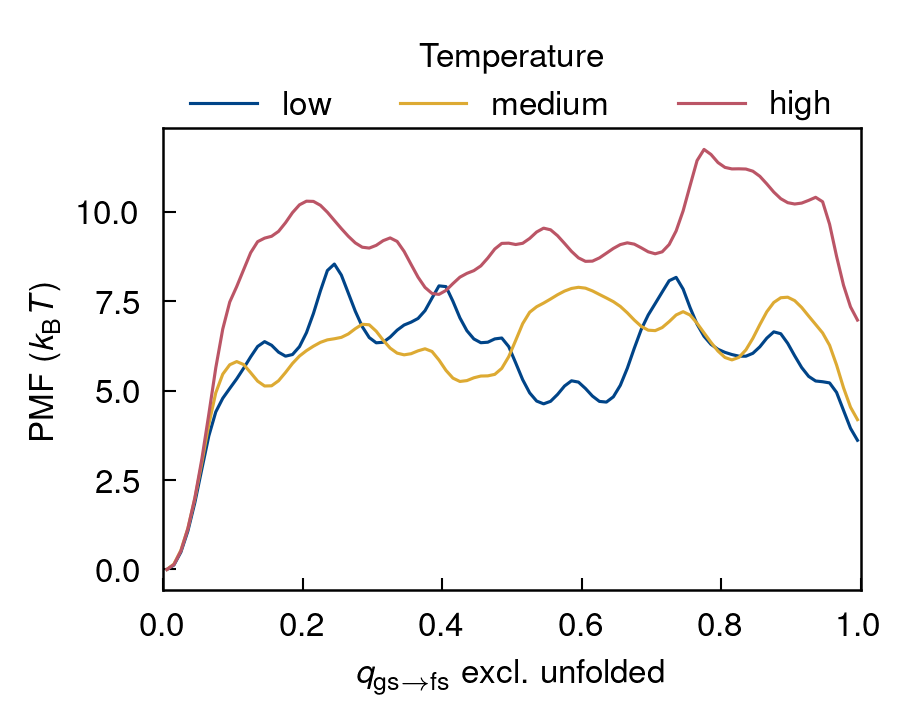

In [25]:
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.02
for qp, w, cvs in zip(qp_withc_all, weights_all_ts, cvs_all_ts):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    hist, xe = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=100)
    xc = (xe[1:] + xe[:-1]) / 2
    min_energy = np.min(-np.log(hist))
    pmf = -np.log(hist) - min_energy
    plt.plot(xc, pmf)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel(r"PMF ($k_{\mathrm{B}}T$)")
plt.xlim([0, 1])
# plt.ylim([-1, 1])
plt.legend(
    ["low", "medium", "high"], title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
plt.show()
# plt.savefig("../../dga/figures/pmf_qp_ts.pdf", bbox_inches='tight')

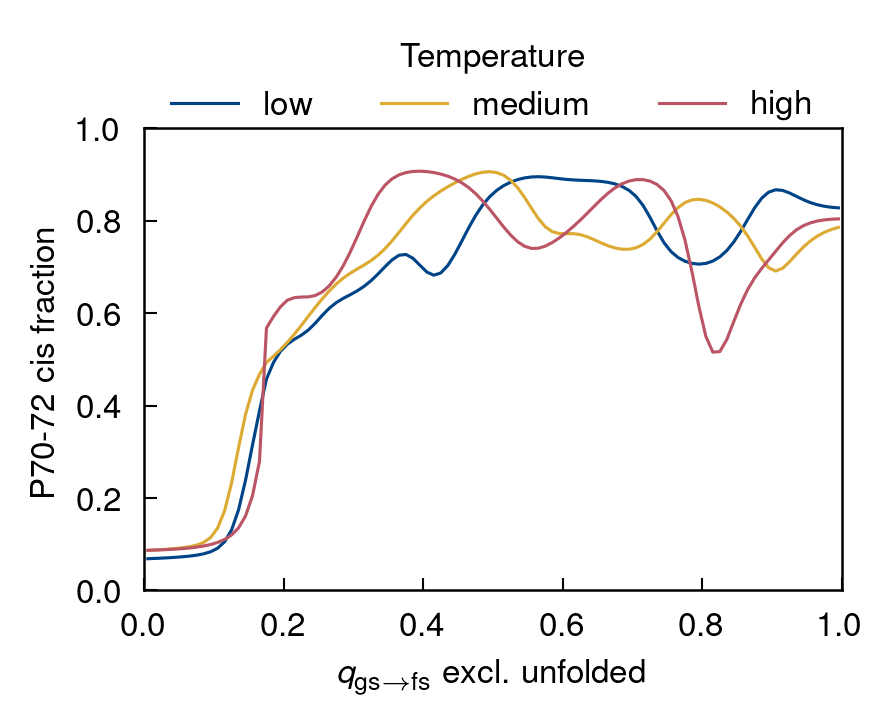

In [26]:
# combine p70-p72
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_withc_all, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['p70'] | cvs['p71'] | cvs['p72']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel("P70-72 cis fraction")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

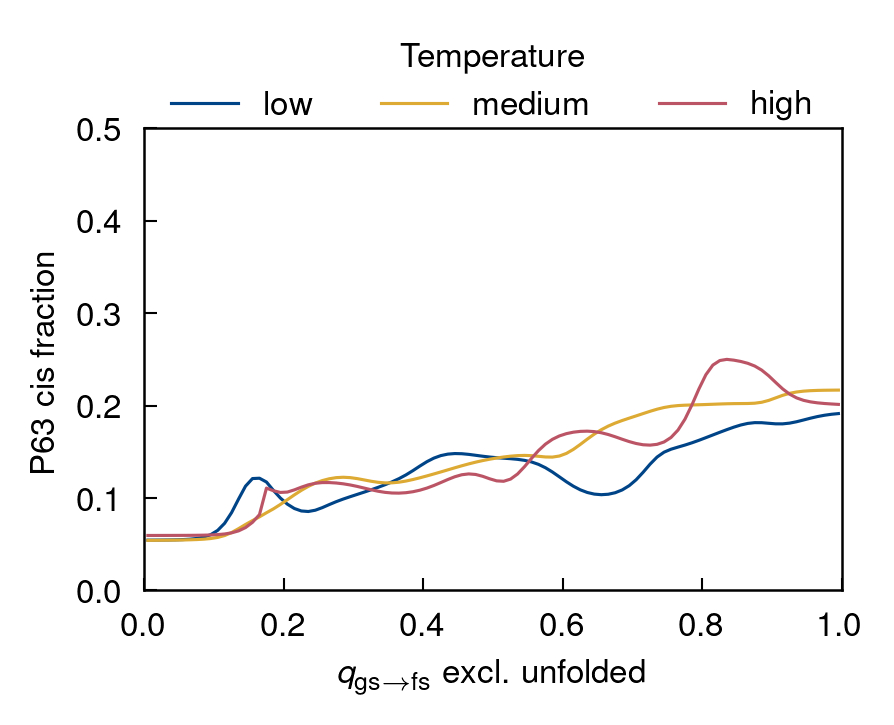

In [27]:
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_withc_all, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['p63']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel("P63 cis fraction")
plt.xlim([0, 1])
plt.ylim([0, 0.5])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

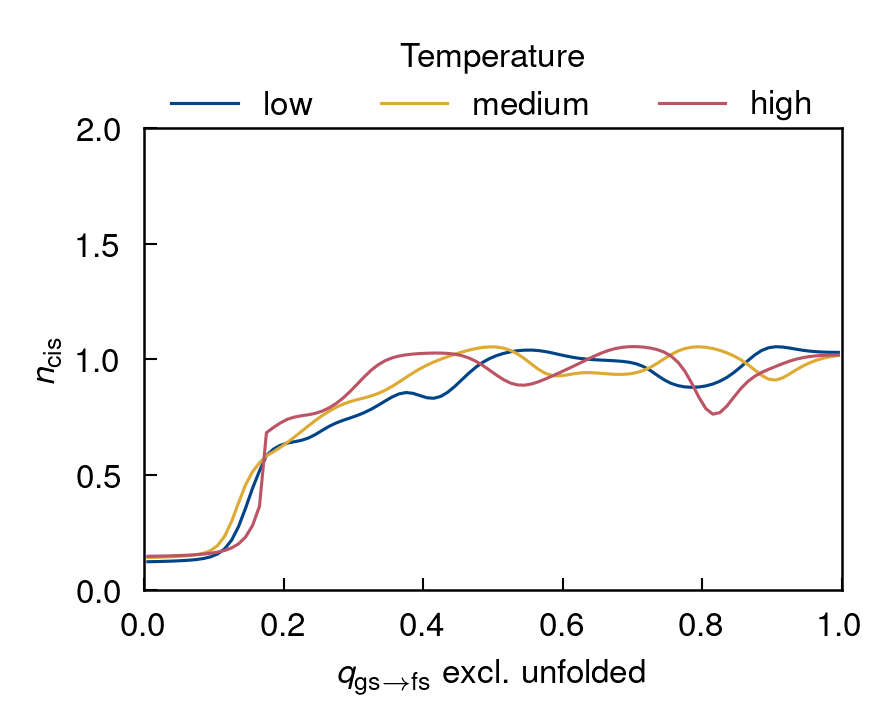

In [28]:
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.04
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_withc_all, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['n_cis']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel(labels['n_cis'])
plt.xlim([0, 1])
plt.ylim([0, 2])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

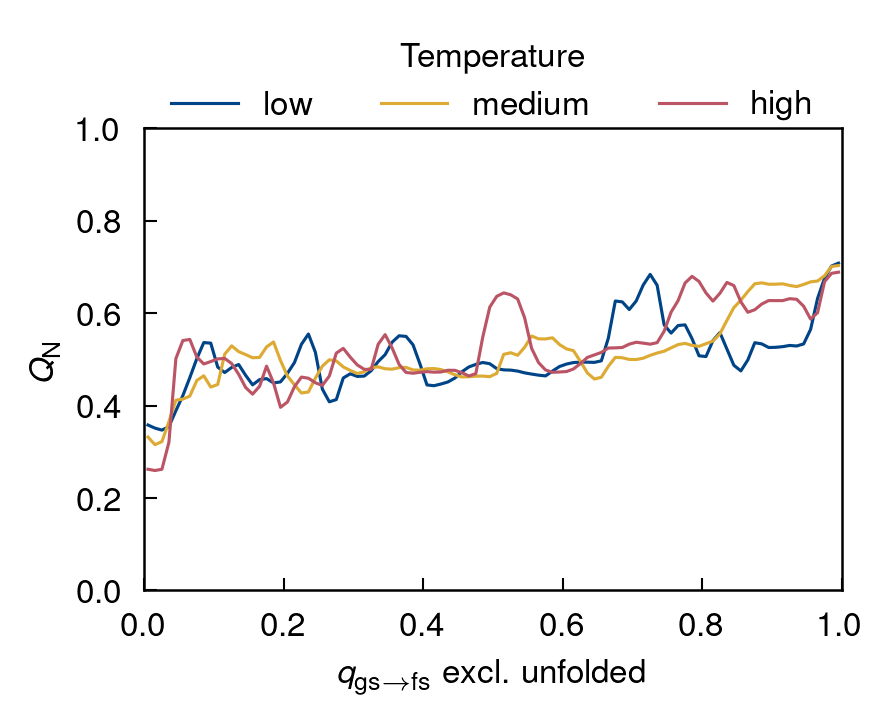

In [29]:
# c-term
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.01
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_withc_all, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['q_core']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel(labels['q_core'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

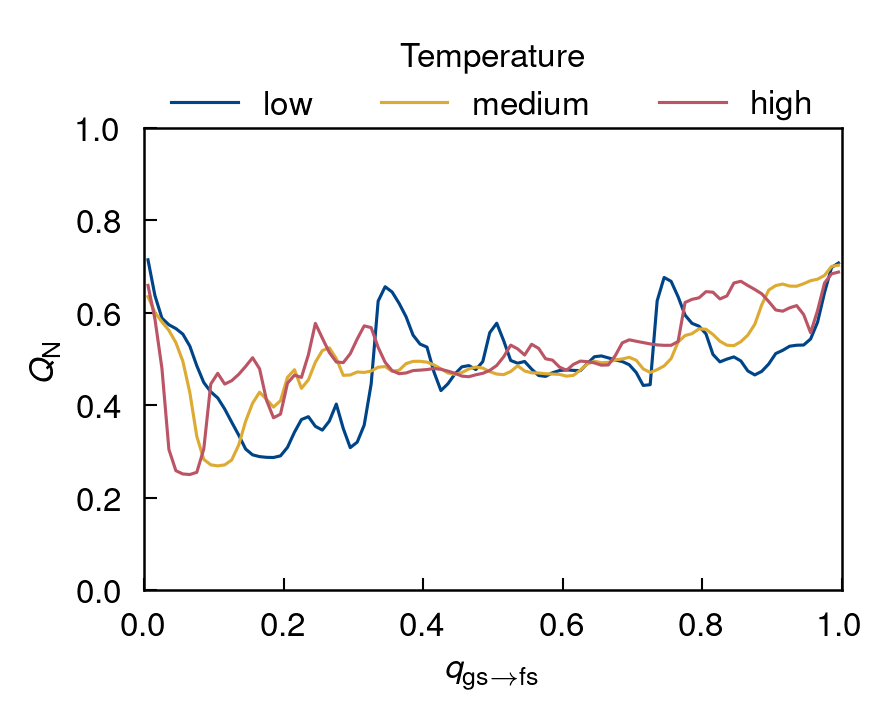

In [30]:
# c-term
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.01
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_all_ts, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['q_core']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$")
plt.ylabel(labels['q_core'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

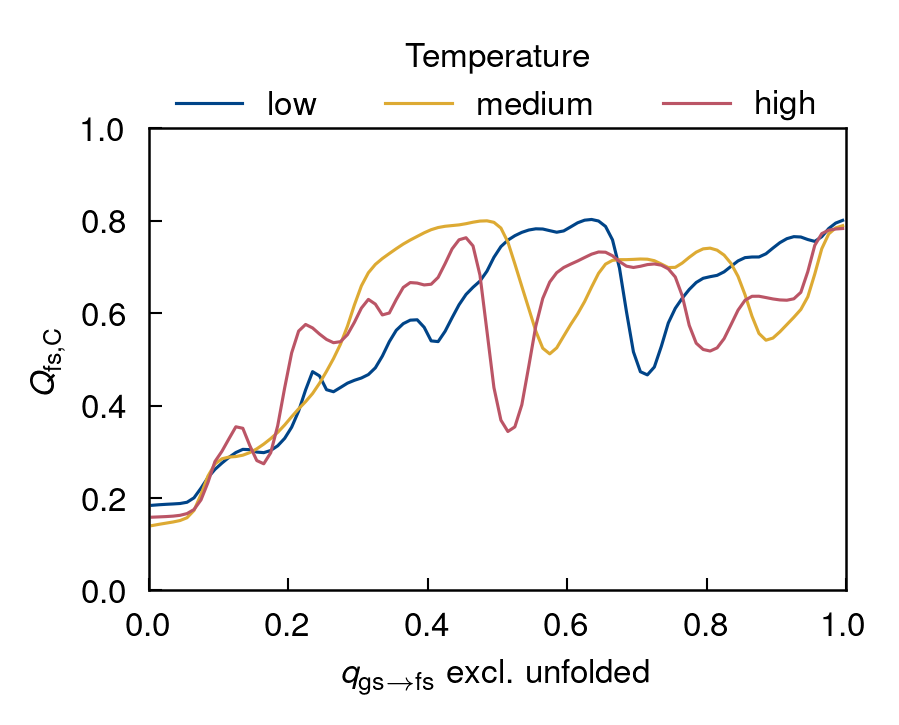

In [31]:
# c-term
fig = plt.figure(figsize=(3, 2), dpi=300)

lag, mem = 100, 1
xstd = 0.02
nx = 100
handles = []
labs = ["low", "medium", "high"]
for qp, w, cvs, label in zip(qp_withc_all, weights_all_ts, cvs_all_ts, labs):
    q = np.asarray(qp)[..., :-lag]
    w = np.broadcast_to(w[..., None], q.shape)
    cv = cvs['q_fs']
    numer, xe = kdesum1d(q, cv[..., :-lag] * w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    
    denom, _ = kdesum1d(q, w, xmin=0, xmax=1, xstd=xstd, nx=nx)
    mean = numer / denom
    xc = (xe[1:] + xe[:-1]) / 2
    line = plt.plot(xc, mean, label=label)
    handles.append(line)
plt.xlabel(r"$q_{\mathrm{gs}\rightarrow\mathrm{fs}}$ excl. unfolded")
plt.ylabel(labels['q_fs'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    title="Temperature", bbox_to_anchor=(0.5, 1.1), loc="center", ncols=3
)
# fig.savefig("../../dga/figures/qp_p7072_ts.pdf", bbox_inches='tight')
plt.show()

# Proline states

In [ ]:
from collections import OrderedDict
from itertools import product

## all prolines

In [ ]:
def assign_prolines(cvs, weights):
    # assign proline states
    dtrajs = np.zeros_like(cvs['p63'], dtype=int)
    state_dict = OrderedDict()
    fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=4)
    
    for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=4), fn_seq_iterator)):
        # fn_seq is something like (Identity, ~, Identity, ~)
        seq = (fn_seq[0](cvs['p63']) & fn_seq[1](cvs['p70']) & fn_seq[2](cvs['p71']) & fn_seq[3](cvs['p72'])).astype(bool)
        state_name = "".join(state)
        print(f"{state_name}: {np.sum(weights[seq]) / np.sum(weights) * 100:6.3f}%")
        state_dict[state_name] = i
        dtrajs[seq] = i
    return dtrajs, state_dict

In [ ]:
dtrajs_all = []
for cvs, weights in zip(cvs_all_ts, weights_all_ts):
    w = np.array(np.broadcast_to(weights[:, None], cvs['p63'].shape))
    dtrajs, state_dict = assign_prolines(cvs, w)
    print("")
    dtrajs_all.append(dtrajs)

In [ ]:
def make_sparse_basis(dtrajs):
    """Converts a discretized trajectory (e.g. from k-means clustering)
    into a sparse basis of indicator functions.

    Parameters
    ----------
    dtrajs : ndarray
        discretized trajectories

    Return
    ------
    basis : scipy.sparse.csr_matrix
    """
    nclusters = len(np.unique(dtrajs))
    rows, cols = [], []
    for i in range(nclusters):
        pts = np.argwhere(dtrajs == i)
        # indices of which frames are in the cluster i
        rows.append(pts.squeeze())
        # all assigned as 1 in the basis
        cols.append(np.repeat(i, len(pts)))
    rows = np.hstack(rows)
    cols = np.hstack(cols)
    data = np.ones(len(rows), dtype=float)
    basis = scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(dtrajs), nclusters))
    return basis

In [ ]:
def make_basis(dtrajs):
    basis_arr = make_sparse_basis(dtrajs.ravel())
    basis = []
    n_traj, n_frame = dtrajs.shape[:2]
    for i in range(n_traj):
        basis.append(basis_arr[i * n_frame : (i + 1) * n_frame])
    return basis


def compute_transition_matrix(basis, weights, lag):
    C0 = 0.0
    Ct = 0.0
    test_basis = basis
    for w, x, y in zip(weights, basis, test_basis):
        wx = scipy.sparse.diags(w) @ x
        C0 += wx[:-lag].T @ y[:-lag]
        Ct += wx[:-lag].T @ y[lag:]
    return scipy.sparse.linalg.inv(C0) @ Ct

### t=0.87

In [ ]:
basis = make_basis(dtrajs_all[0])
w = np.array(np.broadcast_to(weights_all_ts[0][:, None], dtrajs_all[0].shape))
lags = [1, 2, 5, 10, 20, 50, 100, 200]

In [ ]:
tmats = []
for lag in lags:
    tmat = compute_transition_matrix(basis, w, lag)
    tmats.append(tmat)

In [ ]:
f = plt.figure(dpi=300)
plt.imshow(tmats[0].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [ ]:
f = plt.figure(dpi=300)
plt.imshow(tmats[1].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [ ]:
f = plt.figure(dpi=300)
plt.imshow(tmats[-1].A, vmin=0, vmax=0.5)
plt.colorbar(label=r"$p_{ij}$", extend="max")
ax = plt.gca()
ax.set_yticks(np.arange(16), state_dict.keys(), fontsize=6, fontfamily="monospace")
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)
ax.tick_params(color="white", pad=2)

In [ ]:
# implied timescales
eigs = []
for tmat in tmats:
    eigs.append(scipy.sparse.linalg.eigs(tmat, k=8, return_eigenvectors=False))
eigs = np.array(eigs).T

In [ ]:
for eig in eigs:
    plt.plot(lags, lags / -np.log(eig))
plt.fill_between(lags, lags, color='grey', alpha=0.5)
plt.xlim([0, 200])
plt.ylim([0, 1000])

In [ ]:
# implied timescales
evecs = []
for tmat in tmats:
    evecs.append(scipy.sparse.linalg.eigs(tmat, k=2, which='SM')[1][:, 1])
evecs = np.array(evecs)

In [ ]:
fig = plt.figure(dpi=200, figsize=(3, 2))
ax = plt.gca()
for e in evecs:
    plt.plot(e, '.-')
ax.set_xticks(
    np.arange(16),
    state_dict.keys(),
    ha="right",
    rotation_mode="anchor",
    rotation=45,
    fontsize=6,
    fontfamily="monospace",
)

## group P70, P71, P72 together

In [ ]:
def assign_prolines_group2(cvs, weights):
    # assign proline states
    dtrajs = np.zeros_like(cvs['p63'], dtype=int)
    state_dict = OrderedDict()
    fn_seq_iterator = product([lambda x: x, np.logical_not], repeat=2)
    
    for i, (state, fn_seq) in enumerate(zip(product("CT", repeat=2), fn_seq_iterator)):
        # fn_seq is something like (Identity, ~, Identity, ~)
        seq = (fn_seq[0](cvs['p63']) & fn_seq[1](cvs['p70'] | cvs['p71'] | cvs['p72'])).astype(bool)
        state_name = "".join(state)
        print(f"{state_name}: {np.sum(weights[seq]) / np.sum(weights) * 100:6.3f}%")
        state_dict[state_name] = i
        dtrajs[seq] = i
    return dtrajs, state_dict

In [ ]:
dtrajs_all_group2 = []
for cvs, weights in zip(cvs_all_ts, weights_all_ts):
    w = np.array(np.broadcast_to(weights[:, None], cvs['p63'].shape))
    dtrajs, state_dict = assign_prolines_group2(cvs, w)
    print("")
    dtrajs_all_group2.append(dtrajs)

In [ ]:
basis = make_sparse_basis(dtrajs_all_group2[0].ravel())
w = np.repeat(weights_all_ts[0], 1001)

In [ ]:
def compute_transition_matrix(basis, weights, lag, traj_lens):
    C0 = 0.0
    Ct = 0.0
    test_basis = basis
    t_times = []
    curr = 0
    for length in traj_lens:
        t_times.append(np.arange(curr, curr + length - lag))
        curr += length
    t_times = np.concatenate(t_times)
    t_tau_times = t_times + lag
    
    wx = scipy.sparse.diags(weights) @ basis
    C0 += wx[t_times].T @ test_basis[t_times]
    Ct += wx[t_times].T @ test_basis[t_tau_times]
    return scipy.sparse.linalg.inv(C0) @ Ct

In [ ]:
tmats = []
traj_lens = [len(traj) for traj in dtrajs_all_group2[0]]
for lag in lags:
    tmat = compute_transition_matrix(basis, w, lag, traj_lens)
    tmats.append(tmat)

In [ ]:
for tmat in tmats:
    f = plt.figure(dpi=300, figsize=(2, 2))
    plt.imshow(tmat.A, vmin=0, vmax=1)
    plt.colorbar(label=r"$p_{ij}$")
    ax = plt.gca()
    ax.set_yticks(np.arange(4), state_dict.keys(), fontsize=6, fontfamily="monospace")
    ax.set_xticks(
        np.arange(4),
        state_dict.keys(),
        ha="right",
        rotation_mode="anchor",
        rotation=45,
        fontsize=6,
        fontfamily="monospace",
    )
    ax.tick_params(color="white", pad=2)

In [ ]:
# implied timescales
eigs = []
for tmat in tmats:
    eigs.append(scipy.linalg.eig(tmat.toarray())[0])
eigs = np.array(eigs).T

In [ ]:
for eig in eigs:
    plt.plot(lags, lags / -np.log(eig))
plt.fill_between(lags, lags, color='grey', alpha=0.5)
plt.xlim([0, 200])
plt.ylim([0, 1000])

# look